Load necessary libraries.

In [1]:
### Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### ML packages
import umap
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering #Hierarchial Clustering
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

#Msc
import warnings

Load dataset.

In [2]:
df = pd.read_csv('00_authors.csv').rename(columns = {'Unnamed: 0': 'Author'}).drop(columns = 'BookID')
X = df.copy().drop(['Author'], axis=1)
authors = df['Author'].values  # n_samples-length array

In [3]:
K_ = 4 
# number of clusters (assuming we know this - distinct authors = 4)
# we can hyperparameter tune if unknown (in real setting)
# will do validation later in repository

Define relevant function used later.

In [4]:
def labeler(y):
    labels_df = pd.DataFrame(y).reset_index(drop=False).rename(columns = {'index':'Chapters', 0:'Cluster/Author'})
    labels_df['Author'] = df['Author'].values
    cluster_mapping = labels_df.groupby('Cluster/Author')['Author'].apply(lambda x: x.value_counts().idxmax()).to_dict() # Redefining the clustermapping
    cluster_mapping= {v: k for k, v in cluster_mapping.items()} # Swapping the keys and values
    return cluster_mapping, labels_df

# K-Means ++

In [5]:
X = X.to_numpy() # change pd.DataFrame to np.ndarray

K-means ++ below.

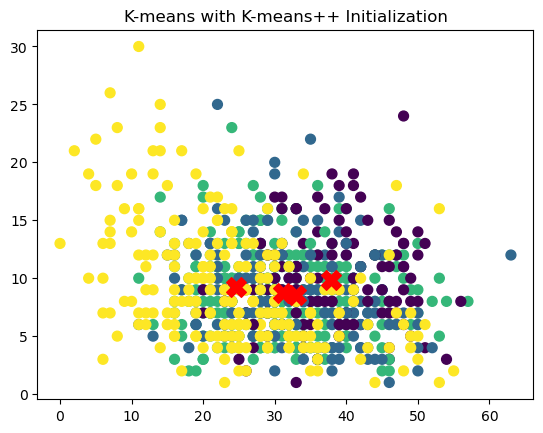

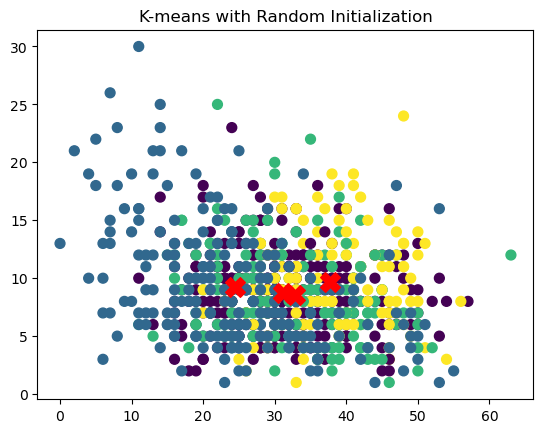

In [6]:
# K-means++ initialization 
kmeans_pp = KMeans(n_clusters=K_, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans_pp.fit(X)
y_kmeans_pp = kmeans_pp.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans_pp, s=50, cmap='viridis')
centers_pp = kmeans_pp.cluster_centers_
plt.scatter(centers_pp[:, 0], centers_pp[:, 1], c='red', s=200, marker='X')
plt.title('K-means with K-means++ Initialization')
plt.show()

# K-means w/ random initialization
kmeans = KMeans(n_clusters=K_, init='random', n_init=10, max_iter=300, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis') # plot
centers = kmeans.cluster_centers_ # centroids
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X') # plot centroids
plt.title('K-means with Random Initialization')
plt.show()

The results are poor, clearly some type of dimensionality reduction should be applied before running k-means++.  Lets apply UMAP and rerun K-means++.

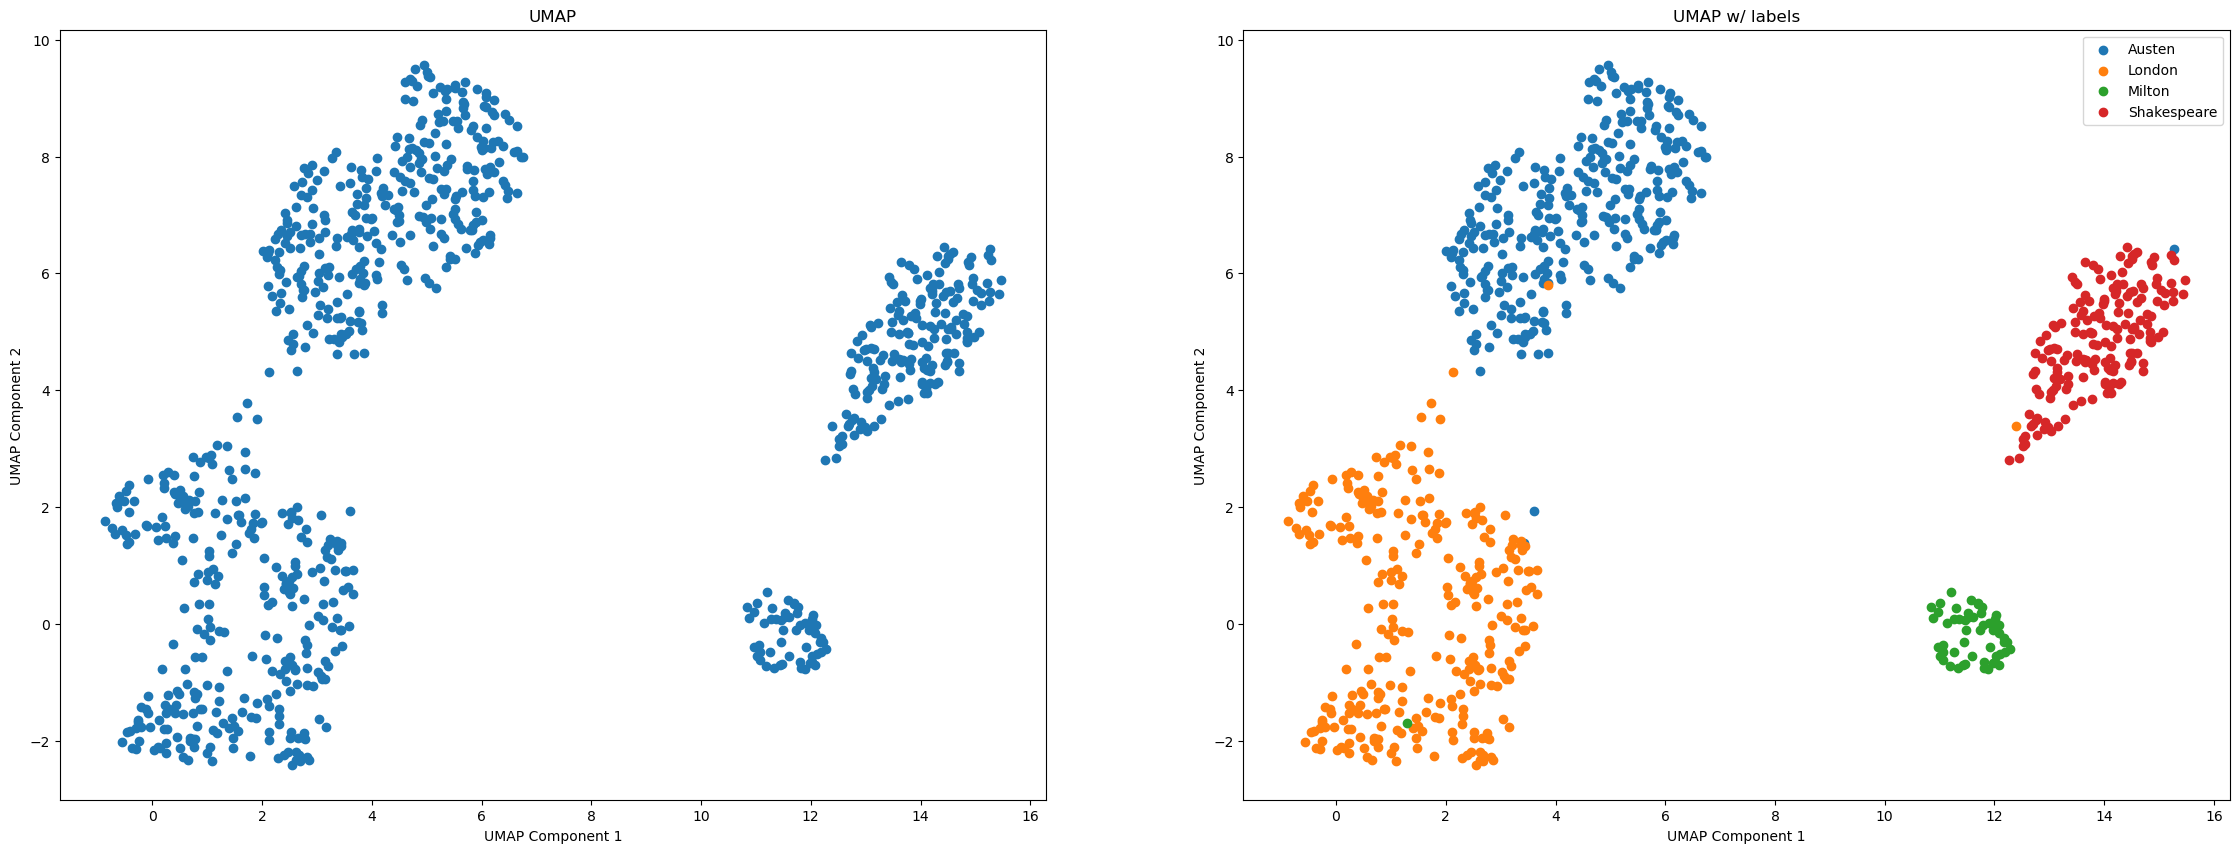

In [7]:
### UMAP
warnings.filterwarnings("ignore", category=UserWarning, module="umap") # Suppress the specific UMAP warning on parralelism
random_state = 42 # reproducibility for analysis
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=random_state);
X_umap = umap_model.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(28, 10))

axes[0].scatter(X_umap[:,0],X_umap[:,1])
axes[0].set_xlabel("UMAP Component 1")
axes[0].set_ylabel("UMAP Component 2")
axes[0].set_title("UMAP")

for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1], label=author)
axes[1].legend(loc="upper right")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("UMAP Component 2")
axes[1].set_title("UMAP w/ labels");



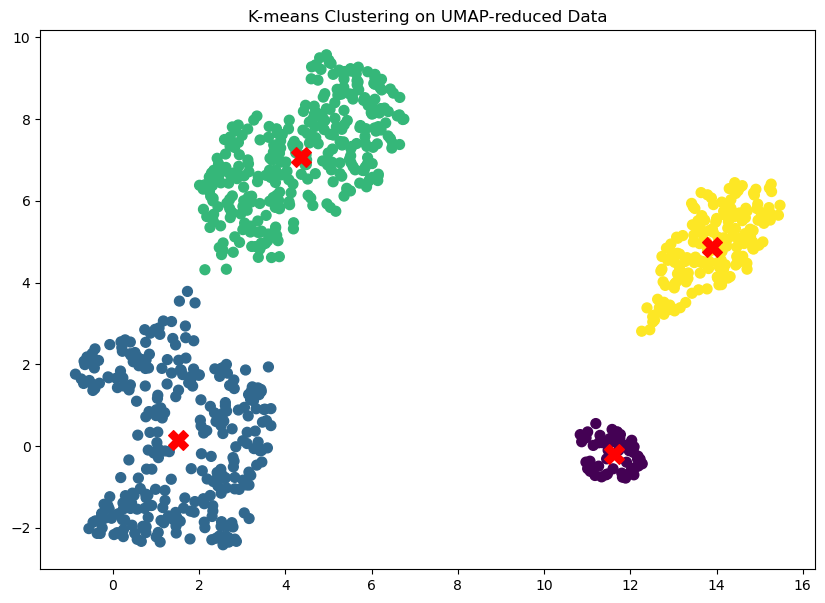

In [8]:
# Run K-means++ on UMAP-reduced data
kmeans = KMeans(n_clusters=K_, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(X_umap)

y_kmeans = kmeans.predict(X_umap) # Predict clusters

plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X')  # Plot centroids
plt.title('K-means Clustering on UMAP-reduced Data')
plt.show()

This is looking a lot better! Now, assuming we didnt have the author labels, we could pull out the labels from the K-means++ and inspect which chapters correspond to which cluster!

In [9]:
centroids = kmeans.cluster_centers_ # Get the centroids of the clusters
print(centroids) # Output the centroids

# Looking at the clusters and our labels from UMAP w/ labels, the following mapping is provided.
cluster_mapping = {'Milton':0, 'London':1, 'Austen':2, 'Shakespeare':3}
print(f'\nMapping: {cluster_mapping}')

[[11.616457   -0.19323611]
 [ 1.5033488   0.14024258]
 [ 4.358289    7.0590777 ]
 [13.906439    4.8637104 ]]

Mapping: {'Milton': 0, 'London': 1, 'Austen': 2, 'Shakespeare': 3}


In [10]:
labels = kmeans.labels_
labels_df = pd.DataFrame(labels).reset_index(drop=False).rename(columns = {'index':'Chapters', 0:'Cluster/Author'})
labels_df['Author'] = df['Author'].values

bool_ = []
for i in range(labels_df.shape[0]):
    if cluster_mapping[labels_df.iloc[i,2]] == labels_df.iloc[i,1]:
        bool_.append(True)
    else:
        bool_.append(False)
labels_df['Correct?'] = bool_
labels_df

,Chapters,Cluster/Author,Author,Correct?
0,0,2,Austen,True
1,1,2,Austen,True
2,2,2,Austen,True
3,3,2,Austen,True
4,4,2,Austen,True
...,...,...,...,...
836,836,3,Shakespeare,True
837,837,3,Shakespeare,True
838,838,3,Shakespeare,True
839,839,3,Shakespeare,True


Lets report our clustering accuracy for K-means ++ using UMAP dimensionality reduction.

In [11]:
print(f'Accuracy = {round(labels_df['Correct?'].mean(),5)}\nMeaning that {round(labels_df['Correct?'].mean(),5)*100}% of the chapters were correctly assigned to the correct author.')

Accuracy = 0.99168
Meaning that 99.168% of the chapters were correctly assigned to the correct author.


Lets save this accuracy into a dictionary and compare it with other clustering methods!

In [12]:
method_accuracy = {}
method_accuracy['kmeans'] = labels_df['Correct?'].mean()

# Gaussian Mixture Models

In [13]:
gmm = GaussianMixture(n_components=K_, random_state=42)  # Fit a Gaussian Mixture Model (GMM) 
gmm.fit(X_umap)                                         # On the UMAP-reduced data
y_gmm = gmm.predict(X_umap) # Predict the clusters for the UMAP-reduced data

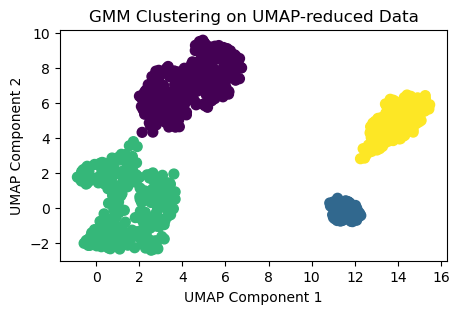

In [14]:
# Visualize the GMM clustering results on UMAP-reduced data
plt.figure(figsize=(5, 3))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_gmm, s=50, cmap='viridis')  # Plot with GMM cluster colors
plt.title("GMM Clustering on UMAP-reduced Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2");

In [15]:
gmm_labels_df = labeler(y_gmm)[1]
cluster_mapping = labeler(y_gmm)[0]
cluster_mapping

{'Austen': 0, 'Milton': 1, 'London': 2, 'Shakespeare': 3}

In [16]:
# Compare the GMM clusters to the actual authors
gmm_bool_ = []
for i in range(gmm_labels_df.shape[0]):
    if cluster_mapping[gmm_labels_df.iloc[i,2]] == gmm_labels_df.iloc[i,1]:
        gmm_bool_.append(True)
    else:
        gmm_bool_.append(False)

gmm_labels_df['Correct?'] = gmm_bool_
print(f'GMM Accuracy = {round(gmm_labels_df["Correct?"].mean(), 5)}\nMeaning that {round(gmm_labels_df["Correct?"].mean(), 5)*100}% of the chapters were correctly assigned to the correct author.')


GMM Accuracy = 0.99168
Meaning that 99.168% of the chapters were correctly assigned to the correct author.


The GMM returned the same results as Kmeans++.

In [17]:
method_accuracy['GMM'] = labels_df['Correct?'].mean()
method_accuracy

{'kmeans': 0.9916765755053508, 'GMM': 0.9916765755053508}

# Spectral Clustering

Spectral Clustering already reduces the dimensionality of the data using the spectral decomposition of the similarity matrix. 

So, if I apply UMAP for consistency of comparison across methods before performing Spectral Clustering, I am effectively reducing the dimensionality twice.

UMAP is another dimensionality reduction technique, and applying it prior to Spectral Clustering might distort the data in a way that interferes with Spectral Clustering's own ability to find the best clusters.

Therefore, I am going to apply Spectral Clustering to the original dataset.

In [18]:
spectral = SpectralClustering(n_clusters=K_, affinity='nearest_neighbors', random_state=42)
y_spectral = spectral.fit_predict(X)

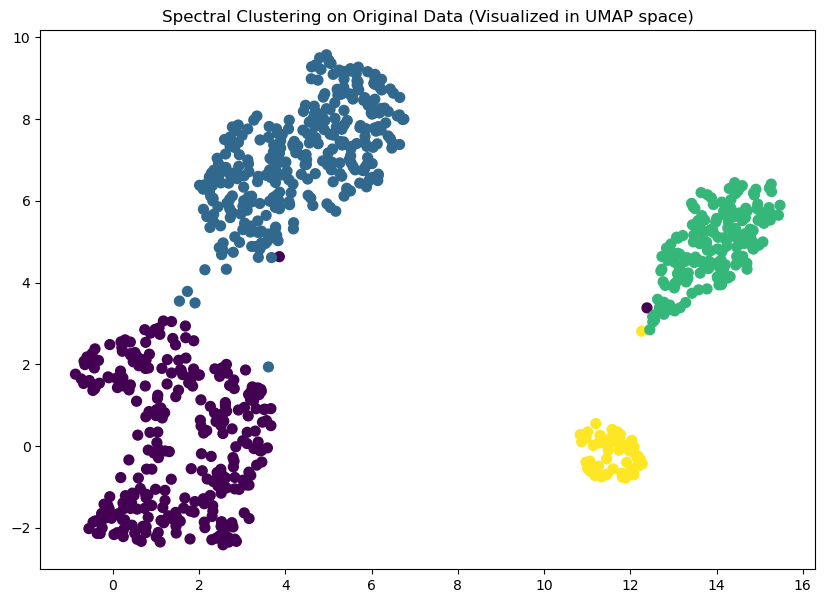

In [19]:
plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_spectral, s=50, cmap='viridis')  # Visualizing clustering on UMAP
plt.title('Spectral Clustering on Original Data (Visualized in UMAP space)')
plt.show()

In [20]:
spectral_labels_df = labeler(y_spectral)[1]
cluster_mapping = labeler(y_spectral)[0]
cluster_mapping

{'London': 0, 'Austen': 1, 'Shakespeare': 2, 'Milton': 3}

In [21]:
# Calculate and print the accuracy for Spectral Clustering
spectral_labels_df['Spectral Cluster/Author'] = y_spectral
bool_spectral = []
for i in range(spectral_labels_df.shape[0]):
    if cluster_mapping[spectral_labels_df.iloc[i, 2]] == spectral_labels_df.iloc[i, 1]:
        bool_spectral.append(True)
    else:
        bool_spectral.append(False)

spectral_labels_df['Spectral Correct?'] = bool_spectral
spectral_accuracy = spectral_labels_df['Spectral Correct?'].mean()

print(f'Spectral Clustering Accuracy = {round(spectral_accuracy, 5)}\nMeaning that {round(spectral_accuracy, 5)*100}% of the chapters were correctly assigned to the correct author.')


Spectral Clustering Accuracy = 0.98811
Meaning that 98.811% of the chapters were correctly assigned to the correct author.


Store the accuracy in the method_accuracy dictionary

In [22]:
method_accuracy['spectral'] = spectral_accuracy
print(method_accuracy)

{'kmeans': 0.9916765755053508, 'GMM': 0.9916765755053508, 'spectral': 0.9881093935790726}


So the spectral clustering performed slighlty worse. This makes sense because we saw in previous notebooks that UMAP appears to outperform Spectral Embeddings in dimension reduction (by creating more distinguished clusters)!

# Hierarchical Clustering

Applying Agglomerative Clustering == Hierarchial Cluster to the UMAP-reduced data. Dimensionality reduction is important here because this algorithm uses distance metrics (in default case, Euclidean distance) to find K = 1,...,n ordered and nested clusters in the data!

In [23]:
# Fitting the model 
hierarchical = AgglomerativeClustering(n_clusters=K_,metric='euclidean',linkage='ward') #ward minimizes within variance of merged clusters & only works with Euclidean distances
y_hierarchical = hierarchical.fit_predict(X_umap)

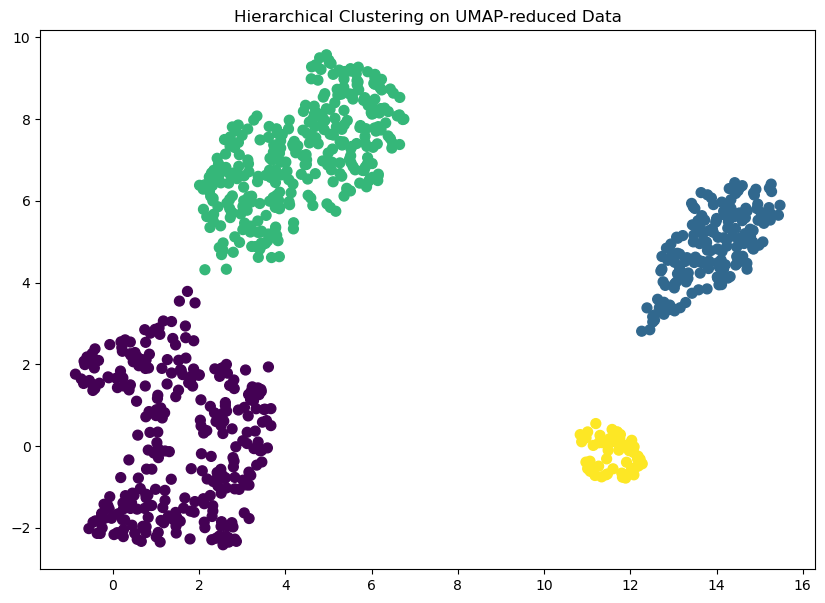

In [24]:
# Visualize the Hierarchical Clustering results on UMAP-reduced data
plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_hierarchical, s=50, cmap='viridis')  # Visualizing on UMAP space
plt.title('Hierarchical Clustering on UMAP-reduced Data')
plt.show()

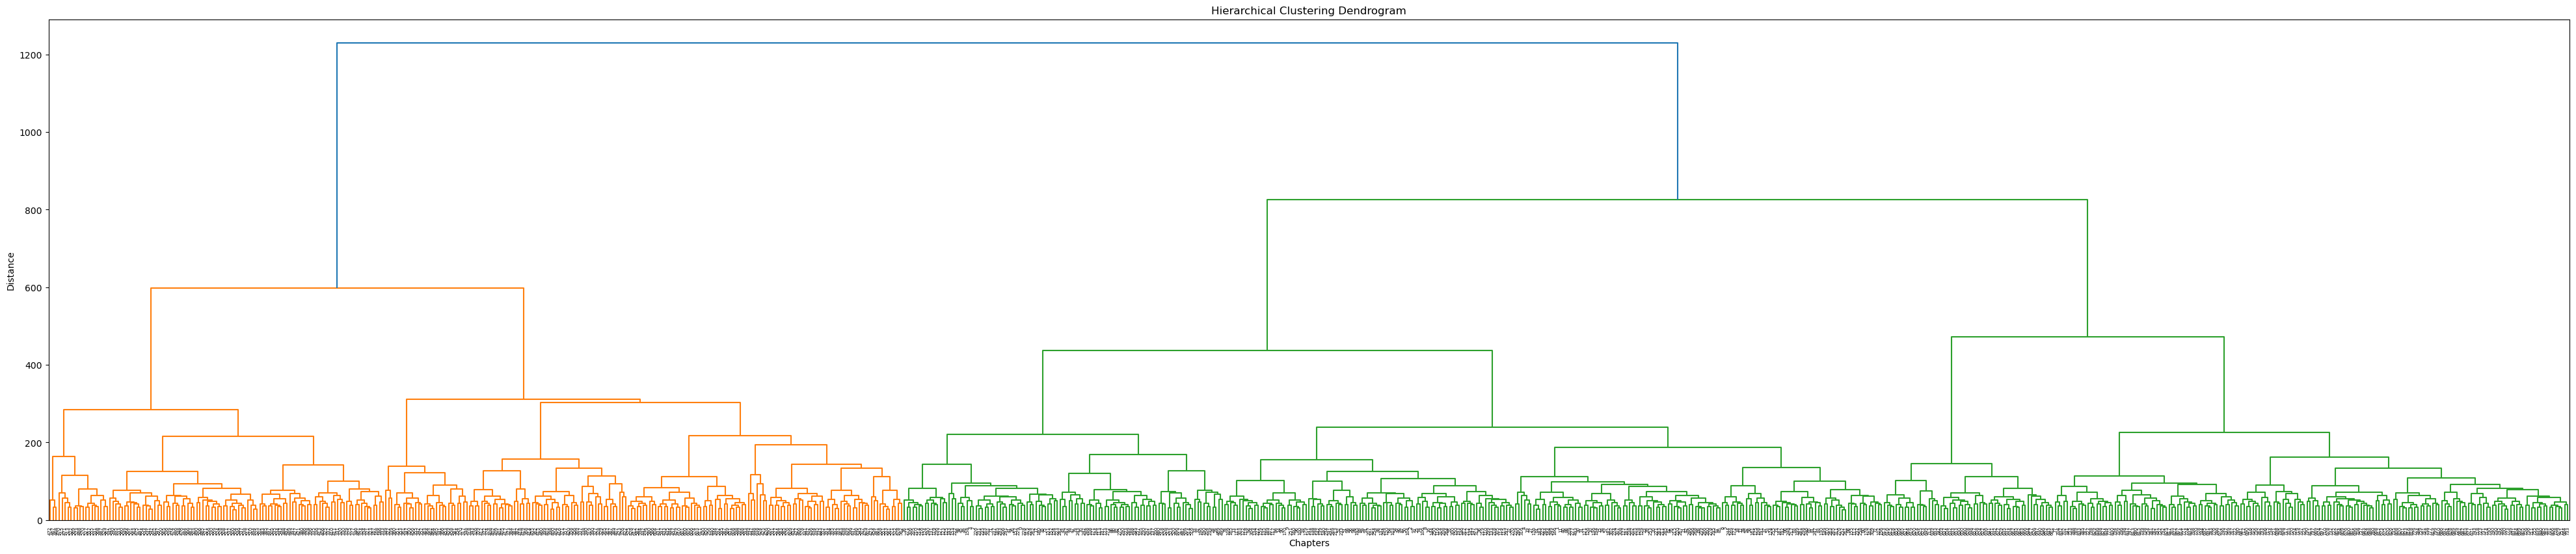

In [25]:
# Creating a dendrogram to visualize the hierarchical clustering process
plt.figure(figsize=(50, 10))
sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Chapters')
plt.ylabel('Distance');
plt.savefig('Dendrogram')

In [26]:
hierarchical_labels_df = labeler(y_hierarchical)[1]
cluster_mapping = labeler(y_hierarchical)[0]
cluster_mapping

{'London': 0, 'Shakespeare': 1, 'Austen': 2, 'Milton': 3}

In [27]:
# Calculate and print the accuracy for Hierarchical Clustering
hierarchical_labels_df['Hierarchical Cluster/Author'] = y_hierarchical
bool_hierarchical = []
for i in range(hierarchical_labels_df.shape[0]):
    if cluster_mapping[hierarchical_labels_df.iloc[i, 2]] == hierarchical_labels_df.iloc[i, 1]:
        bool_hierarchical.append(True)
    else:
        bool_hierarchical.append(False)

hierarchical_labels_df['Hierarchical Correct?'] = bool_hierarchical
hierarchical_accuracy = hierarchical_labels_df['Hierarchical Correct?'].mean()

print(f'Hierarchical Clustering Accuracy = {round(hierarchical_accuracy, 5)}\nMeaning that {round(hierarchical_accuracy, 5)*100}% of the chapters were correctly assigned to the correct author.')

# Store the accuracy in the method_accuracy dictionary
method_accuracy["hierarchical - \n('euclidean', 'ward')"] = hierarchical_accuracy
print(method_accuracy)


Hierarchical Clustering Accuracy = 0.99168
Meaning that 99.168% of the chapters were correctly assigned to the correct author.
{'kmeans': 0.9916765755053508, 'GMM': 0.9916765755053508, 'spectral': 0.9881093935790726, "hierarchical - \n('euclidean', 'ward')": 0.9916765755053508}


Once again the results are the same.  This is because UMAP does a very good job of clustering the data so all the methods that use this dimensional reduction beforehand will yield the same results!

Lets try more hierarchial clustering using different parameters for the linkage and distance!

In [28]:
linkage_options = ['ward', 'complete', 'average', 'single']
other_metric_options = ['manhattan', 'cosine', 'chebyshev', 'minkowski']

In [29]:
metric = other_metric_options[0]
linkage = 'single'

# Fitting the model 
hierarchical = AgglomerativeClustering(n_clusters=K_,metric=metric,linkage=linkage)
y_hierarchical = hierarchical.fit_predict(X_umap)

hierarchical_labels_df = labeler(y_hierarchical)[1]
cluster_mapping = labeler(y_hierarchical)[0]
cluster_mapping

# Calculate and print the accuracy for Hierarchical Clustering
hierarchical_labels_df['Hierarchical Cluster/Author'] = y_hierarchical
bool_hierarchical = []
for i in range(hierarchical_labels_df.shape[0]):
    if cluster_mapping[hierarchical_labels_df.iloc[i, 2]] == hierarchical_labels_df.iloc[i, 1]:
        bool_hierarchical.append(True)
    else:
        bool_hierarchical.append(False)

hierarchical_labels_df['Hierarchical Correct?'] = bool_hierarchical
hierarchical_accuracy = hierarchical_labels_df['Hierarchical Correct?'].mean()

print(f'Hierarchical Clustering Accuracy = {round(hierarchical_accuracy, 5)}\nMeaning that {round(hierarchical_accuracy, 5)*100}% of the chapters were correctly assigned to the correct author.')

# Store the accuracy in the method_accuracy dictionary
method_accuracy[f'hierarchical - \n{metric, linkage}'] = hierarchical_accuracy
print(method_accuracy)


Hierarchical Clustering Accuracy = 0.99168
Meaning that 99.168% of the chapters were correctly assigned to the correct author.
{'kmeans': 0.9916765755053508, 'GMM': 0.9916765755053508, 'spectral': 0.9881093935790726, "hierarchical - \n('euclidean', 'ward')": 0.9916765755053508, "hierarchical - \n('manhattan', 'single')": 0.9916765755053508}


# Comparison

In [30]:
method_accuracy

{'kmeans': 0.9916765755053508,
 'GMM': 0.9916765755053508,
 'spectral': 0.9881093935790726,
 "hierarchical - \n('euclidean', 'ward')": 0.9916765755053508,
 "hierarchical - \n('manhattan', 'single')": 0.9916765755053508}

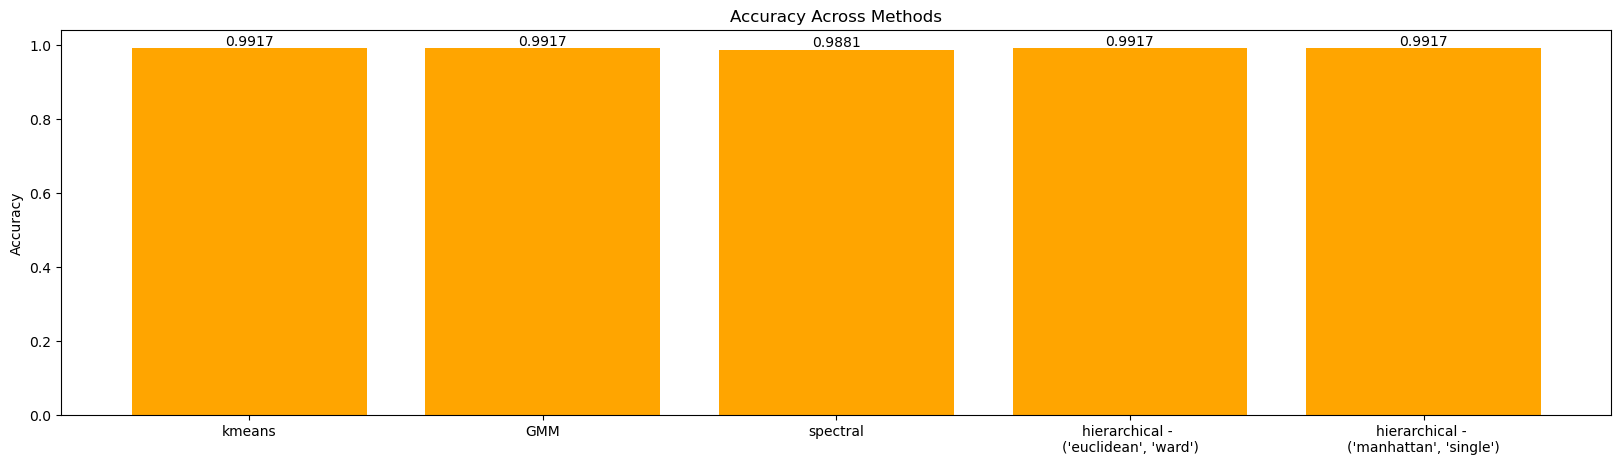

In [31]:
fig, ax = plt.subplots(figsize=(20, 5))
bars = ax.bar(list(method_accuracy.keys()), list(method_accuracy.values()), color='orange')
ax.bar_label(bars, labels=[f'{round(v, 4)}' for v in method_accuracy.values()], color='black')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Across Methods');